# Exploration préliminaire

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display, Markdown

import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import time

from scipy.stats import pearsonr, spearmanr

In [2]:
%matplotlib inline

In [3]:
EdStatsData = pd.read_csv("data/EdStatsData.csv")

## Exploration initiale

In [4]:
EdStatsData.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2060,2065,2070,2075,2080,2085,2090,2095,2100,Unnamed: 69
0,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.F,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.GPI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arab World,ARB,"Adjusted net enrolment rate, lower secondary, ...",UIS.NERA.2.M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,54.822121,54.894138,56.209438,57.267109,57.991138,59.36554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
display(Markdown(f"La base de données est composée de {EdStatsData.shape[0]:,.0f} lignes et {EdStatsData.shape[1]:,.0f} colonnes."))
display(Markdown(f"Les lignes contiennent les informations relatives à {EdStatsData['Country Code'].nunique():,.0f} pays et {EdStatsData['Indicator Code'].nunique():,.0f} indicateurs."))

La base de données est composée de 886,930 lignes et 70 colonnes.

Les lignes contiennent les informations relatives à 242 pays et 3,665 indicateurs.

In [6]:
EdStatsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886930 entries, 0 to 886929
Data columns (total 70 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Country Name    886930 non-null  object 
 1   Country Code    886930 non-null  object 
 2   Indicator Name  886930 non-null  object 
 3   Indicator Code  886930 non-null  object 
 4   1970            72288 non-null   float64
 5   1971            35537 non-null   float64
 6   1972            35619 non-null   float64
 7   1973            35545 non-null   float64
 8   1974            35730 non-null   float64
 9   1975            87306 non-null   float64
 10  1976            37483 non-null   float64
 11  1977            37574 non-null   float64
 12  1978            37576 non-null   float64
 13  1979            36809 non-null   float64
 14  1980            89122 non-null   float64
 15  1981            38777 non-null   float64
 16  1982            37511 non-null   float64
 17  1983      

Les 4 premières colonnes représentent des identifiants uniques indiquant le pays, un code associé, l'indicateur observé et son code associé. Les 65 suivantes représentent l'année de l'observation, en pas annuel de 1970 à 2017, et quinquennal de 2020 à 2100. La dernière colonne est vide, et peut être retirée sans perte d'information.

## Mise en forme de la base de données

In [7]:
EdStatsData.drop("Unnamed: 69", axis = 1, inplace = True)

Afin de faciliter l'utilisation de cette base de données, nous allons dans un premier temps utiliser la fonction `df.melt()` de pandas pour regrouper les dates dans une nouvelle colonne, et l'ensemble des observations dans une seconde colonne.

In [8]:
EdStatsData = EdStatsData.melt(
    id_vars = ["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name = "Year",
    value_name = "Value"
)

In [9]:
EdStatsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650450 entries, 0 to 57650449
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Country Name    object 
 1   Country Code    object 
 2   Indicator Name  object 
 3   Indicator Code  object 
 4   Year            object 
 5   Value           float64
dtypes: float64(1), object(5)
memory usage: 2.6+ GB


La base de données résultante est donc composée de 6 colonnes, dont une contenant l'ensemble des observations, et s'étend sur 57 650 449 lignes.
On peut noter que la colonne contenant les années est au format "object", ce qui n'est pas optimal pour l'analyse à venir. Nous allons donc commencer par changer son format pour en faire une colonne de int.

In [10]:
EdStatsData['Year'] = EdStatsData['Year'].astype("int")

Nous avons pu voir que la base de départ couvre une période s'étendant de 1970 à 2100. Pour les besoins de notre analyse, nous allons réduire cet intervalle à une période couvrant 2000 (débuts de la croissance forte de l'accès à internet) à 2030 (en estimant cet intervalle de temps propice à des projections restant réalistes).

In [11]:
EdStatsData = EdStatsData[EdStatsData["Year"].between(2000,2030)]

Nous allons ensuite utiliser la fonction `df.pivot()` de pandas pour convertir notre colonne contenant les noms d'indicateurs en autant de colonnes qu'il y a d'indicateurs.

In [12]:
EdStatsData = EdStatsData.pivot(
    index = ["Country Name", "Country Code", "Year"],
    columns = ["Indicator Name"],
    values = "Value"
)

In [13]:
EdStatsData.reset_index(inplace = True)

In [14]:
EdStatsData.head()

Indicator Name,Country Name,Country Code,Year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)",...,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Male,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total,"Youth illiterate population, 15-24 years, % female","Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)"
0,Afghanistan,AFG,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
EdStatsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Columns: 3668 entries, Country Name to Youth literacy rate, population 15-24 years, male (%)
dtypes: float64(3665), int64(1), object(2)
memory usage: 142.2+ MB


In [16]:
display(Markdown(f"Notre base de données contient désormais {EdStatsData.shape[1]:,.0f} colonnes représentant l'ensemble des indicateurs, et {EdStatsData.shape[0]:,.0f} lignes représentant des couples (pays, année)."))

Notre base de données contient désormais 3,668 colonnes représentant l'ensemble des indicateurs, et 5,082 lignes représentant des couples (pays, année).

## Filtrage des pays

Pour notre analyse à venir, nous avons besoin d'identifier les pays au sein des observations disponibles. Pour ce faire, nous allons utiliser une seconde base de données contenant la liste des pays et quelques identifiants associés.

In [17]:
EdStatsCountry = pd.read_csv("data/EdStatsCountry.csv")
EdStatsCountry.head()

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data,Unnamed: 31
0,ABW,Aruba,Aruba,Aruba,AW,Aruban florin,SNA data for 2000-2011 are updated from offici...,Latin America & Caribbean,High income: nonOECD,AW,...,NaN,2010,NaN,NaN,Yes,NaN,NaN,2012.0,NaN,NaN
1,AFG,Afghanistan,Afghanistan,Islamic State of Afghanistan,AF,Afghan afghani,Fiscal year end: March 20; reporting period fo...,South Asia,Low income,AF,...,General Data Dissemination System (GDDS),1979,"Multiple Indicator Cluster Survey (MICS), 2010/11","Integrated household survey (IHS), 2008",NaN,2013/14,NaN,2012.0,2000,NaN
2,AGO,Angola,Angola,People's Republic of Angola,AO,Angolan kwanza,"April 2013 database update: Based on IMF data,...",Sub-Saharan Africa,Upper middle income,AO,...,General Data Dissemination System (GDDS),1970,"Malaria Indicator Survey (MIS), 2011","Integrated household survey (IHS), 2008",NaN,2015,NaN,NaN,2005,NaN
3,ALB,Albania,Albania,Republic of Albania,AL,Albanian lek,NaN,Europe & Central Asia,Upper middle income,AL,...,General Data Dissemination System (GDDS),2011,"Demographic and Health Survey (DHS), 2008/09",Living Standards Measurement Study Survey (LSM...,Yes,2012,2010.0,2012.0,2006,NaN
4,AND,Andorra,Andorra,Principality of Andorra,AD,Euro,NaN,Europe & Central Asia,High income: nonOECD,AD,...,NaN,2011. Population figures compiled from adminis...,NaN,NaN,Yes,NaN,NaN,2006.0,NaN,NaN


In [18]:
EdStatsCountry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 32 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Country Code                                       241 non-null    object 
 1   Short Name                                         241 non-null    object 
 2   Table Name                                         241 non-null    object 
 3   Long Name                                          241 non-null    object 
 4   2-alpha code                                       238 non-null    object 
 5   Currency Unit                                      215 non-null    object 
 6   Special Notes                                      145 non-null    object 
 7   Region                                             214 non-null    object 
 8   Income Group                                       214 non-null    object 
 9   WB-2 code 

Parmi ces identifiants, nous allons nous intéresser au code pays, à la région géographique associée, et à la classification économique du pays.

In [19]:
EdStatsCountry = EdStatsCountry.loc[:,['Country Code', 'Region', 'Income Group']]

Nous utilisons la fonction `df.merge()` de pandas pour compléter notre base initiale en ajoutant les informations de cette seconde base de données. La méthode `"left"` est utilisée pour préciser que nous ne souhaitons extraire que les éléments présents dans notre base initiale.

In [20]:
EdStatsData = EdStatsData.merge(
    right = EdStatsCountry,
    how = 'left',
    on = 'Country Code'
)

In [21]:
EdStatsData.loc[EdStatsData['Region'].isna(),"Country Name"].unique().tolist()

['Arab World',
 'British Virgin Islands',
 'East Asia & Pacific',
 'East Asia & Pacific (excluding high income)',
 'Euro area',
 'Europe & Central Asia',
 'Europe & Central Asia (excluding high income)',
 'European Union',
 'Gibraltar',
 'Heavily indebted poor countries (HIPC)',
 'High income',
 'Latin America & Caribbean',
 'Latin America & Caribbean (excluding high income)',
 'Least developed countries: UN classification',
 'Low & middle income',
 'Low income',
 'Lower middle income',
 'Middle East & North Africa',
 'Middle East & North Africa (excluding high income)',
 'Middle income',
 'Nauru',
 'North America',
 'OECD members',
 'South Asia',
 'Sub-Saharan Africa',
 'Sub-Saharan Africa (excluding high income)',
 'Upper middle income',
 'World']

In [22]:
EdStatsData.loc[EdStatsData['Country Name'].isin(['British Virgin Islands','Gibraltar','Nauru']),["Population, total"]].max()

Population, total    34408.0
dtype: float64

Nous voyons alors que les groupements géographiques qui ne sont pas des pays n'ont pas d'indicateur `Region` associé, ce qui nous permet de facilement les identifier et les retirer de notre base de données. On peut noter que 3 territoires, British Virgin Islands, Gibraltar et Nauru, seront aussi retirés en procédant ainsi. Compte tenu de leur taille et de leur population, leur absence ne devrait pas impacter matériellement notre analyse, et nous proposons de procéder quand même.

In [23]:
EdStatsData.dropna(axis = 0, subset = ['Region'], inplace = True)
EdStatsData.reset_index(inplace = True, drop = True)

In [24]:
del EdStatsCountry

In [25]:
EdStatsData.head()

,Country Name,Country Code,Year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)",...,"Youth illiterate population, 15-24 years, % female","Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)",Region,Income Group
0,Afghanistan,AFG,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income
1,Afghanistan,AFG,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income
2,Afghanistan,AFG,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income
3,Afghanistan,AFG,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income
4,Afghanistan,AFG,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,South Asia,Low income


In [26]:
EdStatsData.shape

(4494, 3670)

In [27]:
nb_countries = EdStatsData.loc[:,["Country Name","Income Group"]].groupby("Income Group").nunique()
nb_countries.columns = ['Original data']

## Exclusion des pays soumis à sanctions économiques ou diplomatiques UE

Avant de continuer notre analyse, nous pouvons nous interroger sur la pertinence de conserver l'ensemble des pays du monde dans notre base de données. 

Il est en effet probable que pour cette première expansion à l'international, notre attention se tourne vers les pays dans lesquels relativement peu de freins existent à la mise en place de notre activité depuis la France.

Dans ce but, nous proposons donc d'exclure dès à présent de notre analyse les pays soumis à des sanctions économiques ou diplomatiques de la part de l'Union Européenne. Bien que ces sanctions ne s'appliquent pas toujours à notre domaine d'activité, la présence sur cette liste indique néanmoins doit des relations complexes avec l'UE, soit une situation locale dégradée, ce qui peut rendre complexe l'accès au marché.

Un [site internet officiel de la Commission Européenne](https://sanctionsmap.eu/#/main) reprend une liste d'Etats pour lesquels des sanctions sont en place.

In [28]:
url = "https://sanctionsmap.eu/#/main"

In [29]:
response = requests.get(url)
response.status_code

200

La donnée dont nous avons besoin étant chargée au travers d'un script JavaScript, nous allons utiliser `selenium` pour créer une instance de navigateur avec `geckodriver` afin de charger la page intégralement, avant de procéder à l'extraction des données contenues.

In [30]:
options = webdriver.FirefoxOptions()
options.add_argument('--headless')
browser = webdriver.Firefox(options=options)

In [31]:
browser.get(url)
time.sleep(5)

In [32]:
html = browser.page_source

In [33]:
response_BS = BeautifulSoup(html, 'html5lib')

En sélectionnant les tags qui contiennent les noms de pays, nous obtenons une liste d'Etats.

In [34]:
country_html = response_BS.find_all('li', attrs={'_ngcontent-c5':"", 'data-heading':"Country or Category"})

In [35]:
country_list = []
for country in country_html:
    country_list.append(country.a.text)

country_list = pd.unique(country_list).tolist()
country_list

['Afghanistan',
 'Belarus',
 'Bosnia & Herzegovina',
 'Burundi',
 'Central African Republic',
 'Chemical weapons',
 'China',
 'Cyber-attacks',
 "Democratic People's Republic of Korea (DPRK – North Korea)",
 'Democratic Republic of the Congo',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Human rights',
 'Iran',
 'Iraq',
 'Lebanon',
 'Libya',
 'Mali',
 'Moldova',
 'Montenegro',
 'Myanmar (Burma)',
 'Nicaragua',
 'Russia',
 'Serbia',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Syria',
 'Terrorism',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'United States',
 'Venezuela',
 'Yemen',
 'Zimbabwe']

Cette liste est comparée à la liste d'Etats contenue dans notre base de données. Les Etats qui n'apparaissent pas dans notre base sont identifiés, et nous cherchons ensuite des noms proches afin de les corriger.

In [36]:
EdStatsData_countries = pd.Series(EdStatsData['Country Name'].unique())

country_diff = np.setdiff1d(country_list, EdStatsData_countries)
country_diff.tolist()

['Bosnia & Herzegovina',
 'Chemical weapons',
 'Cyber-attacks',
 "Democratic People's Republic of Korea (DPRK – North Korea)",
 'Democratic Republic of the Congo',
 'Human rights',
 'Iran',
 'Myanmar (Burma)',
 'Russia',
 'Syria',
 'Terrorism',
 'Venezuela',
 'Yemen']

In [37]:
close_names = []
for country in country_diff:
    for string in country.split(sep = " "):
        temp = EdStatsData_countries[EdStatsData_countries.str.contains(string.replace('(',"").replace(')',""))]
        close_names.extend(temp)
    
close_names = pd.unique(close_names).tolist()
close_names

['Bosnia and Herzegovina',
 'Central African Republic',
 'Czech Republic',
 'Dominican Republic',
 'Kyrgyz Republic',
 'Slovak Republic',
 'Syrian Arab Republic',
 'Isle of Man',
 'Korea, Dem. People’s Rep.',
 'Korea, Rep.',
 'Northern Mariana Islands',
 'Netherlands',
 'St. Vincent and the Grenadines',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Iran, Islamic Rep.',
 'Myanmar',
 'Russian Federation',
 'Venezuela, RB',
 'Yemen, Rep.']

In [38]:
for country in country_diff:
    country_list.remove(country)
    
country_list.extend([
    'Bosnia and Herzegovina',
    'Congo, Dem. Rep.',
    'Iran, Islamic Rep.',
    'Korea, Dem. People’s Rep.',
    'Myanmar',
    'Russian Federation',
    'Syrian Arab Republic',
    'Venezuela, RB',
    'Yemen, Rep.'
])

En ayant corrigé les noms de certains pays pour refléter ceux qui sont présents dans notre base, nous obtenons une liste d'Etats à exclure.

In [39]:
country_list

['Afghanistan',
 'Belarus',
 'Burundi',
 'Central African Republic',
 'China',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Lebanon',
 'Libya',
 'Mali',
 'Moldova',
 'Montenegro',
 'Nicaragua',
 'Serbia',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'United States',
 'Zimbabwe',
 'Bosnia and Herzegovina',
 'Congo, Dem. Rep.',
 'Iran, Islamic Rep.',
 'Korea, Dem. People’s Rep.',
 'Myanmar',
 'Russian Federation',
 'Syrian Arab Republic',
 'Venezuela, RB',
 'Yemen, Rep.']

Bien qu'ils apparaissent dans la liste, nous conservons Etats-Unis et Chine dans notre base : le premier car les seules mesures concernent la protection contre l'extra-territorialité de certaines décisions de justice du pays, le second car les sanctions ne s'appliquent qu'au commerce d'armes.

In [40]:
kept_countries = ['United States', 'China']
country_list = [country for country in country_list if country not in kept_countries]
country_list

['Afghanistan',
 'Belarus',
 'Burundi',
 'Central African Republic',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Lebanon',
 'Libya',
 'Mali',
 'Moldova',
 'Montenegro',
 'Nicaragua',
 'Serbia',
 'Somalia',
 'South Sudan',
 'Sudan',
 'Tunisia',
 'Turkey',
 'Ukraine',
 'Zimbabwe',
 'Bosnia and Herzegovina',
 'Congo, Dem. Rep.',
 'Iran, Islamic Rep.',
 'Korea, Dem. People’s Rep.',
 'Myanmar',
 'Russian Federation',
 'Syrian Arab Republic',
 'Venezuela, RB',
 'Yemen, Rep.']

Nous pouvons désormais excluire ces pays de notre base de données.

In [41]:
EdStatsData = EdStatsData.loc[~EdStatsData['Country Name'].isin(country_list),:]

In [42]:
del country_list, kept_countries, country_diff, close_names, html, browser, response, response_BS

In [43]:
EdStatsData.head()

,Country Name,Country Code,Year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)",...,"Youth illiterate population, 15-24 years, % female","Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)",Region,Income Group
21,Albania,ALB,2000,84.558281,83.848213,0.98360,85.246353,95.889877,95.191872,0.98591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Central Asia,Upper middle income
22,Albania,ALB,2001,85.306610,84.769829,0.98771,85.824432,94.327347,94.161636,0.99659,...,45.34702,2994.0,1358.0,1636.0,99.43515,99.49808,1.0013,99.36846,Europe & Central Asia,Upper middle income
23,Albania,ALB,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Central Asia,Upper middle income
24,Albania,ALB,2003,NaN,NaN,NaN,NaN,91.710312,91.469643,0.99494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Central Asia,Upper middle income
25,Albania,ALB,2004,NaN,NaN,NaN,NaN,91.111290,91.431938,1.00682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Central Asia,Upper middle income


In [44]:
EdStatsData.shape

(3843, 3670)

In [45]:
EdStatsData.loc[:,["Country Name","Income Group"]].groupby("Income Group").nunique()

,Country Name
Income Group,
High income: OECD,31
High income: nonOECD,43
Low income,22
Lower middle income,43
Upper middle income,44


In [46]:
nb_countries_add = EdStatsData.loc[:,["Country Name","Income Group"]].groupby("Income Group").nunique()
nb_countries_add.columns = ['No sanctions']
nb_countries = nb_countries.merge(nb_countries_add, how = 'left', on = 'Income Group')

## Langages par pays

Une autre information qui pourrait s'avérer utile pour l'élaboration d'une stratégie est la langue pratiquée dans le pays. Bien que cette information de soit pas disponible dans les bases de données éducatives à notre disposition, c'est un élément qui peut se trouver sur internet.
Nous allons utiliser l'information disponible sur le [CIA factbook](https://www.cia.gov/the-world-factbook/field/languages/) pour ce faire, grâce à un peu de web scraping, en utilisant BeautifulSoup.

In [47]:
url = "https://www.cia.gov/the-world-factbook/field/languages/"

In [48]:
response = requests.get(url)
response.status_code

200

In [49]:
response_BS = BeautifulSoup(response.text, 'html5lib')

Après nous être assurés que la page web est disponible, nous avons pu utiliser l'inspecteur d'éléments du navigateur pour identifier les tags et classes html qui contiennent les données que nous recherchons. Nous allons utiliser une boucle `for` pour les extraire sous forme de list, que nous convertirons ensuite en DataFrame pour faciliter sa lecture et sa manipulation.

In [50]:
country_fields = response_BS.find_all('li', attrs = {'class':""})

In [51]:
country_lang = []
for country in country_fields:
    country_name = country.find_all("h2")[0].a.text
    
    #La lecture du code html montre qu'au moins un des éléments itérés ne contient pas de child, donc nous utilisons une instruction try: except: pour gérer ces situations.    
    try:
        country_languages = list(country.find_all("p")[0].strings)[0]
    except:
        country_languages = np.nan
        
    country_lang.append([country_name, country_languages])

In [52]:
country_lang = pd.DataFrame(country_lang, columns = ["CIA Country", "Languages"])
country_lang.head()

,CIA Country,Languages
0,Afghanistan,"Afghan Persian or Dari (official, lingua franc..."
1,Akrotiri,"English, Greek"
2,Albania,Albanian 98.8% (official - derived from Tosk d...
3,Algeria,"Arabic (official), French (lingua franca), Ber..."
4,American Samoa,Samoan 88.6% (closely related to Hawaiian and ...


In [53]:
country_lang.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CIA Country  240 non-null    object
 1   Languages    238 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


In [54]:
display(Markdown(f"Nous avons maintenant à notre disposition une base contenant {country_lang.shape[0]} observations avec le nom du pays et les langues qui y sont parlées."))

Nous avons maintenant à notre disposition une base contenant 240 observations avec le nom du pays et les langues qui y sont parlées.

Cependant, cette base ayant une source différente de notre base centrale, nous allons procéder avec précaution pour les joindre. En effet, rien ne garantit à ce stade que les noms des pays sont saisis de façon identique dans les deux cas.
Pour ce faire, nous allons extraire la liste des pays de notre base de données éducative, et créer une colonne dédiée à être une clé commune aux deux bases.

In [55]:
EdStatsData_lang = pd.DataFrame(EdStatsData['Country Name'].unique(), columns = ["Country Name"])

In [56]:
EdStatsData_lang.loc[:,"CIA Country"] = EdStatsData_lang['Country Name']

In [57]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [58]:
np.setdiff1d(EdStatsData_lang["CIA Country"], country_lang["CIA Country"]).tolist()

['Brunei Darussalam',
 'Channel Islands',
 'Congo, Rep.',
 'Czech Republic',
 'Egypt, Arab Rep.',
 'Hong Kong SAR, China',
 'Korea, Rep.',
 'Kyrgyz Republic',
 'Lao PDR',
 'Macao SAR, China',
 'Macedonia, FYR',
 'Micronesia, Fed. Sts.',
 'Sint Maarten (Dutch part)',
 'Slovak Republic',
 'St. Kitts and Nevis',
 'St. Lucia',
 'St. Martin (French part)',
 'St. Vincent and the Grenadines',
 'Swaziland',
 'Virgin Islands (U.S.)',
 'West Bank and Gaza']

Cette liste de pays apparaît dans notre base de données éducatives, mais ne porte vraisemblablement pas le même nom dans la base contenants les informations sur les langues parlées.

In [59]:
np.setdiff1d(country_lang["CIA Country"], EdStatsData_lang["CIA Country"]).tolist()

['Afghanistan',
 'Akrotiri',
 'Anguilla',
 'Belarus',
 'Bosnia and Herzegovina',
 'British Virgin Islands',
 'Brunei',
 'Burma',
 'Burundi',
 'Central African Republic',
 'Christmas Island',
 'Cocos (Keeling) Islands',
 'Congo, Democratic Republic of the',
 'Congo, Republic of the',
 'Cook Islands',
 'Czechia',
 'Dhekelia',
 'Egypt',
 'Eswatini',
 'European Union',
 'Falkland Islands (Islas Malvinas)',
 'Gaza Strip',
 'Gibraltar',
 'Guernsey',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Holy See (Vatican City)',
 'Hong Kong',
 'Iran',
 'Iraq',
 'Jersey',
 'Korea, North',
 'Korea, South',
 'Kyrgyzstan',
 'Laos',
 'Lebanon',
 'Libya',
 'Macau',
 'Mali',
 'Micronesia, Federated States of',
 'Moldova',
 'Montenegro',
 'Montserrat',
 'Nauru',
 'Nicaragua',
 'Niue',
 'Norfolk Island',
 'North Macedonia',
 'Pitcairn Islands',
 'Russia',
 'Saint Barthelemy',
 'Saint Helena, Ascension, and Tristan da Cunha',
 'Saint Kitts and Nevis',
 'Saint Lucia',
 'Saint Martin',
 'Saint Pierre and Miquelon',
 

A l'inverse, cette liste de pays apparaît dans la base contenants les informations sur les langues parlées, mais ne porte vraisemblablement pas le même nom dans la base de données éducatives qui nous intéresse.

In [60]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_colwidth', 15)

Nous allons donc associer les noms entre les deux bases, sur une colonne dédiée de notre base de données éducative, en complétant manuellement les noms différents pour refléter ceux de la base contenant les données linguistiques.

In [61]:
EdStatsData_lang.loc[~EdStatsData_lang['Country Name'].isin(country_lang["CIA Country"]),'CIA Country'] = [
    "Brunei",
    "United Kingdom",
    "Congo, Republic of the",
    "Czechia",
    "Egypt",
    "Hong Kong",
    "Korea, South",
    "Kyrgyzstan",
    "Laos",
    "Macau",
    "North Macedonia",
    "Micronesia, Federated States of",
    "Sint Maarten",
    "Slovakia",
    "Saint Kitts and Nevis",
    "Saint Lucia",
    "Saint Martin",
    "Saint Vincent and the Grenadines",
    "Eswatini",
    "Virgin Islands",
    "West Bank"
]

Ces deux bases peuvent maintenant être associées, afin de compléter notre base de pays provenant de la base de données éducatives avec l'information sur les langues parlées.

In [62]:
EdStatsData_lang = EdStatsData_lang.merge(
    right = country_lang,
    on = "CIA Country",
    how = "left"
)

In [63]:
EdStatsData_lang['Languages'].isna().sum()

0

On peut voir qu'il n'y a pas de données manquantes dans la nouvelle colonne indiquant les langues.

In [64]:
EdStatsData_lang.head()

,Country Name,CIA Country,Languages
0,Albania,Albania,Albanian 98...
1,Algeria,Algeria,Arabic (off...
2,American Samoa,American Samoa,Samoan 88.6...
3,Andorra,Andorra,Catalan (of...
4,Angola,Angola,Portuguese ...


La colonne "CIA Country" n'étant désormais plus utile, nous la retirons de la base de données.

In [65]:
EdStatsData_lang.drop("CIA Country", axis = 1, inplace  = True)

On peut désormais joindre notre base de données éducatives à la base de données par pays, afin de compléter la première avec l'information sur les langues parlées.

In [66]:
EdStatsData = EdStatsData.merge(
    right = EdStatsData_lang,
    how = 'left',
    on = 'Country Name'
)

In [67]:
del EdStatsData_lang, country_lang

In [68]:
EdStatsData.head()

,Country Name,Country Code,Year,"Adjusted net enrolment rate, lower secondary, both sexes (%)","Adjusted net enrolment rate, lower secondary, female (%)","Adjusted net enrolment rate, lower secondary, gender parity index (GPI)","Adjusted net enrolment rate, lower secondary, male (%)","Adjusted net enrolment rate, primary, both sexes (%)","Adjusted net enrolment rate, primary, female (%)","Adjusted net enrolment rate, primary, gender parity index (GPI)",...,"Youth illiterate population, 15-24 years, both sexes (number)","Youth illiterate population, 15-24 years, female (number)","Youth illiterate population, 15-24 years, male (number)","Youth literacy rate, population 15-24 years, both sexes (%)","Youth literacy rate, population 15-24 years, female (%)","Youth literacy rate, population 15-24 years, gender parity index (GPI)","Youth literacy rate, population 15-24 years, male (%)",Region,Income Group,Languages
0,Albania,ALB,2000,84.558281,83.848213,0.98360,85.246353,95.889877,95.191872,0.98591,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Ce...,Upper middl...,Albanian 98...
1,Albania,ALB,2001,85.306610,84.769829,0.98771,85.824432,94.327347,94.161636,0.99659,...,2994.0,1358.0,1636.0,99.43515,99.49808,1.0013,99.36846,Europe & Ce...,Upper middl...,Albanian 98...
2,Albania,ALB,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Ce...,Upper middl...,Albanian 98...
3,Albania,ALB,2003,NaN,NaN,NaN,NaN,91.710312,91.469643,0.99494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Ce...,Upper middl...,Albanian 98...
4,Albania,ALB,2004,NaN,NaN,NaN,NaN,91.111290,91.431938,1.00682,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Europe & Ce...,Upper middl...,Albanian 98...


In [69]:
EdStatsData.shape

(3843, 3671)

## Sélection des indicateurs

Afin de rationaliser la sélection des indicateurs qui nous seront utiles pour l'analyse, nous allons commencer par regarder lesquels sont suffisamment complétés pour pouvoir différencier les pays entre eux.

In [70]:
EdStatsData.isna().sum()/EdStatsData.shape[0]

Country Name                                                              0.000000
Country Code                                                              0.000000
Year                                                                      0.000000
Adjusted net enrolment rate, lower secondary, both sexes (%)              0.651054
Adjusted net enrolment rate, lower secondary, female (%)                  0.660161
                                                                            ...   
Youth literacy rate, population 15-24 years, gender parity index (GPI)    0.886027
Youth literacy rate, population 15-24 years, male (%)                     0.886027
Region                                                                    0.000000
Income Group                                                              0.000000
Languages                                                                 0.000000
Length: 3671, dtype: float64

On voit dans cet échantillon que certains indicateurs sont remplis à moins de 20% sur les années retenues, ce qui risque de limiter leur utilité. Par ailleurs, on peut voir que certains indicateurs sont limités à un sexe en particulier, ce qui ne va pas nous être utile à ce stade pour déterminer les pays à plus fort potentiel.

Afin d'automatiser l'approche avec python, nous allons créer une fonction pour faire une pré-sélection d'indicateurs selon les critères suivants :
- ratio maximal d'observations manquantes que nous acceptons
- mots que nous souhaitons exclure des indicateurs

In [71]:
def indicator_filter(data, na_threshold, filtered_words = []):
    
    '''
    Fonction filtrant la liste de colonnes (= les indicateurs) en fonction du nombre de valeurs manquantes et d'une liste de mots à exclure.
    
    Paramètres
    ----------
    data : données à filtrer, format DataFrame, dont les noms de colonnes sont uniques.
    na_threshold : ratio maximal de valeurs manquantes au-delà duquel l'indicateur est rejeté.
    filtered_words : mots ou liste de mots à exclure, format itérable (list, ndarray, tuple, dict).
    
    Résultat
    --------
    ndarray contenant l'ensemble des indicateurs passant les deux filtres.
    
    '''
    
    length = data.shape[0]
    filtered_words = '|'.join(filtered_words)
    
    if EdStatsData.columns.nunique() != len(data.columns):
        raise ValueError("La liste d'indicateurs (noms de colonnes) ne doit contenir que des valeurs uniques.")
    
    indicators_retained = data.loc[:,~data.columns.str.contains(filtered_words, case = False)]
    
    indicators_retained = indicators_retained.dropna(axis = 1, thresh = int((1-na_threshold) * length))
    
    indicators_retained = indicators_retained.columns.tolist()
    
    return np.array(indicators_retained)

Nous savons que la base de données contient des données réelles et des projections. Il se peut que certains indicateurs seulement soient projetés, tandis que d'autres contiennent uniquement des valeurs observées. Afin de différencier les deux, nous allons définir une année pivot au-delà de laquelle les données sont considérées comme projetées. Nous avons pu repérer que les mesures annuelles cessent en 2017, année que nous allons considérer comme pivot.

In [72]:
max_actuals = 2017

Nous définissons ensuite le ratio maximal d'observations manquantes que nous acceptons, ainsi que des listes de mots à exclure.

Afin de définir le ratio maximal d'observations manquantes, nous allons observer le nombre d'indicateurs restant sur différents ratios allant de 10% à 70%. Nous cherchons à conserver une liste d'environ 50 indicateurs, en conservant ainsi un nombre suffisant d'indicateurs pour pouvoir faire une sélection plus avancée en fonction des besoins de notre analyse.

In [73]:
words_actuals = ["male", "primary", "parity", "Population, age", "grade", "GNI", "PPP", "constant"]
words_forecasts = ["male", "primary", "mean", "no education", "percentage"]

In [74]:
actuals_thresh = []
forecasts_thresh = []

for i in np.arange(0.1, 0.8, 0.1):
    actuals_thresh.append(len(indicator_filter(EdStatsData[EdStatsData['Year'] <= max_actuals], i, words_actuals)))
    forecasts_thresh.append(len(indicator_filter(EdStatsData[EdStatsData['Year'] > max_actuals], i, words_forecasts)))
    
    thresholds = {
        'missing threshold': np.arange(0.1, 0.8, 0.1),
        'remaining actuals': actuals_thresh,
        'remaining forecasts': forecasts_thresh
    }

pd.DataFrame(thresholds)

,missing threshold,remaining actuals,remaining forecasts
0,0.1,8,6
1,0.2,23,6
2,0.3,26,18
3,0.4,40,18
4,0.5,53,18
5,0.6,74,18
6,0.7,120,18


Nous pouvons voir qu'à partir de 50% d'éléments manquants pour les valeurs réelles, nous obtenons environ 50 indicateurs à analyser. Concernant les données prospectives, il n'y a pas de changement à partir de 30% de valeurs manquantes.

In [75]:
actuals_indicators = indicator_filter(EdStatsData[EdStatsData['Year'] <= max_actuals], 0.5, words_actuals)
forecasts_indicators = indicator_filter(EdStatsData[EdStatsData['Year'] > max_actuals], 0.3, words_forecasts)

In [76]:
print(f"Nombre d'indicateurs retenus pour les valeurs observées : {len(actuals_indicators)}")
print(f"Nombre d'indicateurs retenus pour les valeurs projetées : {len(forecasts_indicators)}")

Nombre d'indicateurs retenus pour les valeurs observées : 53
Nombre d'indicateurs retenus pour les valeurs projetées : 18


Cette première étape nous a permis de réduire fortement le nombre d'indicateurs à étudier. Nous pouvons maintenant continuer à réduire cette liste en sélectionnant manuellement les indicateurs que nous pensons les plus utiles.

In [77]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [78]:
pd.DataFrame(actuals_indicators, columns = ['Indicators'])

,Indicators
0,Country Name
1,Country Code
2,Year
3,Duration of compulsory education (years)
4,"Enrolment in lower secondary education, both sexes (number)"
5,"Enrolment in lower secondary education, public institutions, both sexes (number)"
6,"Enrolment in lower secondary general, both sexes (number)"
7,"Enrolment in secondary education, both sexes (number)"
8,"Enrolment in secondary general, both sexes (number)"
9,"Enrolment in secondary vocational, both sexes (number)"


In [79]:
pd.DataFrame(forecasts_indicators, columns = ['Indicators'])

,Indicators
0,Country Name
1,Country Code
2,Year
3,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Total
4,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Post Secondary. Total
5,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Upper Secondary. Total
6,Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Lower Secondary. Total
7,Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total
8,Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Upper Secondary. Total
9,Wittgenstein Projection: Population age 25-29 in thousands by highest level of educational attainment. Lower Secondary. Total


Sur la base de ce premier filtre, nous pouvons désormais sélectionner une liste d'indicateurs qui pourront être utiles pour estimer l'opportunité dans chacun des pays.

Pour ce faire, nous proposons de retenir les indicateurs suivants 
- Indicateurs d'identification : Nom du pays, code pays, région, zone économique
- Langues parlées, afin d'étudier si une approche par langue est possible
- Année de l'observation
- PIB (en US\\$ courants), Population totale, PIB par habitant (en US\\$ courants), afin d'affiner le type d'approche possible pour chaque pays retenu
- Nombre d'utilisateurs d'internet pour 100 habitants, pour estimer le marché potentiel pour notre service en ligne
- Nombre d'élèves du secondaire, pour estimer le marché potentiel total sur ce segment
- Nombre d'élèves du tertiaire, pour estimer le marché potentiel total sur ce segment
- Données prospectives en nombre, couvrant la population entre 15 et 29 ans et estimant leur niveau maximal d'étude atteint entre secondaire et tertiaire, afin d'essayer de construire des projections du nombre d'élèves

Nous pouvons dans un premier temps observer une matrice de corrélation entre les indicateurs identifiés pour les années passées.

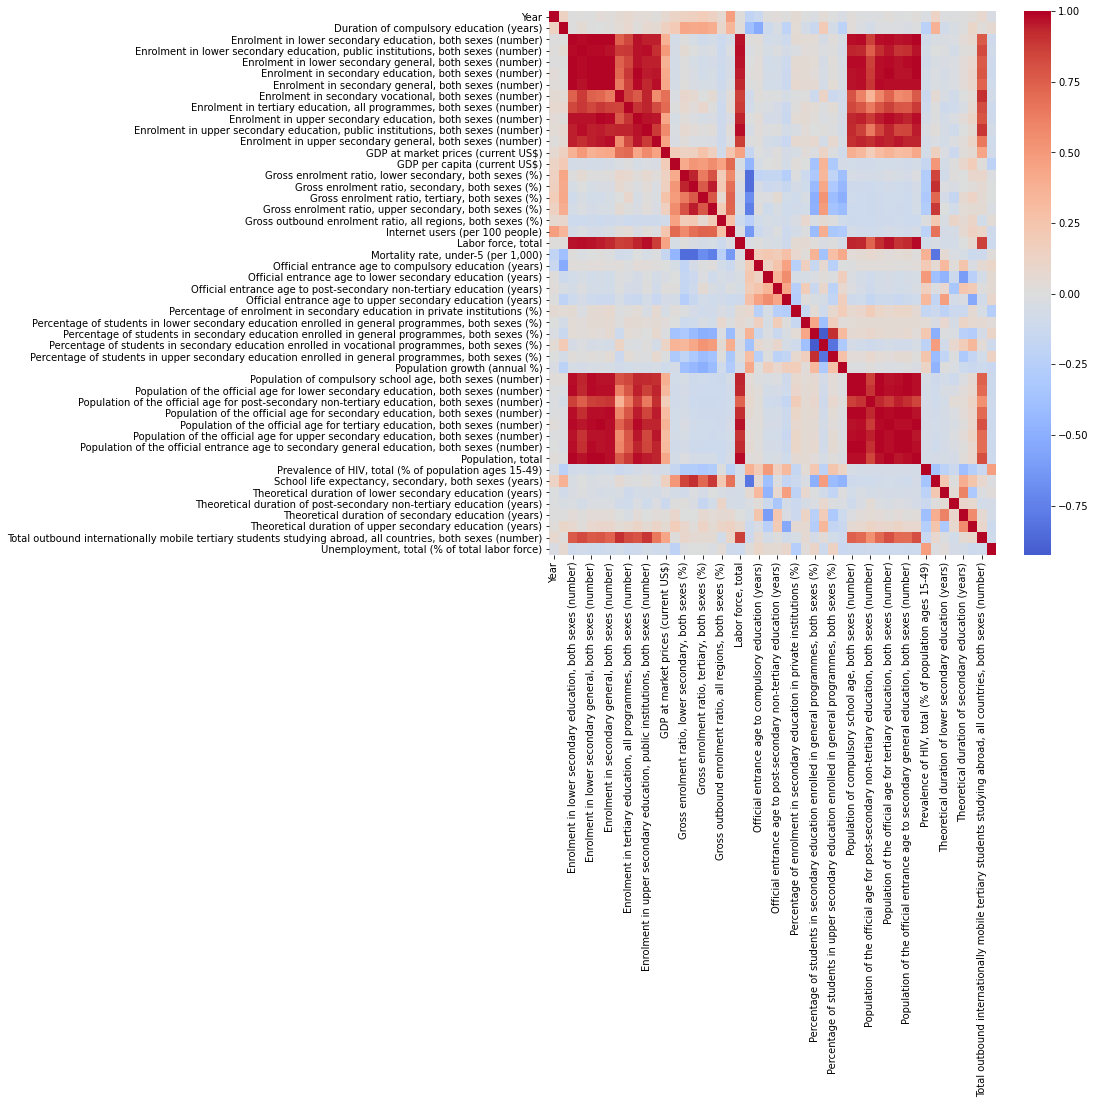

In [80]:
EdStatsData_corr = EdStatsData.loc[EdStatsData['Year'] <= max_actuals,actuals_indicators].corr()

fig, ax = plt.subplots(figsize = (10,10))

sns.heatmap(
    data = EdStatsData_corr,
    cmap = "coolwarm",
    center = 0)

plt.show()

In [81]:
country_indicators = actuals_indicators[[0,1,-3,-2,-1,2]].tolist()
actuals_indicators = actuals_indicators[[14,41,15,21,7,10]].tolist()
forecasts_indicators = forecasts_indicators[[3,5,8,4,7,10]].tolist()
indicators_retained = country_indicators + actuals_indicators + forecasts_indicators

In [82]:
display(Markdown(f"Nous retenons donc les indicateurs suivants:"))
for indicator in indicators_retained:
    display(Markdown(f"- {indicator}"))

Nous retenons donc les indicateurs suivants:

- Country Name

- Country Code

- Region

- Income Group

- Languages

- Year

- GDP at market prices (current US$)

- Population, total

- GDP per capita (current US$)

- Internet users (per 100 people)

- Enrolment in secondary education, both sexes (number)

- Enrolment in tertiary education, all programmes, both sexes (number)

- Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Total

- Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Upper Secondary. Total

- Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Upper Secondary. Total

- Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Post Secondary. Total

- Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total

- Wittgenstein Projection: Population age 25-29 in thousands by highest level of educational attainment. Post Secondary. Total

Nous pouvons maintenant revoir notre base de données en ne conservant que les colonnes contenant les indicateurs retenus.

In [83]:
EdStatsData = EdStatsData.loc[:, indicators_retained].reset_index(drop = True)

In [84]:
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_colwidth', 15)

In [85]:
EdStatsData.head()

,Country Name,Country Code,Region,Income Group,Languages,Year,GDP at market prices (current US$),"Population, total",GDP per capita (current US$),Internet users (per 100 people),"Enrolment in secondary education, both sexes (number)","Enrolment in tertiary education, all programmes, both sexes (number)",Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Lower Secondary. Total,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Upper Secondary. Total,Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Upper Secondary. Total,Wittgenstein Projection: Population age 15-19 in thousands by highest level of educational attainment. Post Secondary. Total,Wittgenstein Projection: Population age 20-24 in thousands by highest level of educational attainment. Post Secondary. Total,Wittgenstein Projection: Population age 25-29 in thousands by highest level of educational attainment. Post Secondary. Total
0,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2000,3.632044e+09,3089027.0,1175.788981,0.114097,365664.0,40125.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2001,4.060759e+09,3060173.0,1326.970339,0.325798,377936.0,40859.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2002,4.435079e+09,3051010.0,1453.642777,0.390081,382205.0,42160.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2003,5.746946e+09,3039616.0,1890.681557,0.971900,396095.0,43600.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2004,7.314865e+09,3026939.0,2416.588235,2.420388,393503.0,53014.0,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
EdStatsData.shape

(3843, 18)

## Sélection d'un indicateur clé

Nous avons retenu deux indicateurs centraux que nous estimons être les plus importants pour la première étape d'estimation du potentiel du marché. Ces indicateurs sont:
- Le nombre d'élèves inscrits au secondaire
- Le nombre d'élèves inscrits au tertiaire

Néanmoins, il est possible qu'un de ces deux indicateurs soit plus complet que l'autre.

In [87]:
indicator_secondary = 'Enrolment in secondary education, both sexes (number)'
indicator_tertiary = 'Enrolment in tertiary education, all programmes, both sexes (number)'

In [88]:
EdStatsData.loc[:,[indicator_secondary, indicator_tertiary]].isna().sum()

Enrolment in secondary education, both sexes (number)                   1789
Enrolment in tertiary education, all programmes, both sexes (number)    2036
dtype: int64

On peut voir que l'indicateur donnant le nombre d'élèves inscrits au secondaire contient moins de données manquantes que celui donnant le nombre d'élèves inscrits dans un parcours tertiaire.

Cependant, il est probable que ces deux indicateurs soient corrélés : en effet, il est probable qu'un pays qui contient beaucoup d'élèves de secondaire ait aussi une forte population scolarisée dans le tertiaire. Si cela était le cas, nous pourrions nous baser sur le premier indicateur pour définir notre stratégie géographique. Pour étudier cela, nous allons dans un premier temps présenter les deux données dans un nuage de points, afin d'observer la forme générale de la relation entre ces indicateurs, avant d'étudier plus en détail la corrélation entre les données au travers des coefficients de Pearson et Spearman.

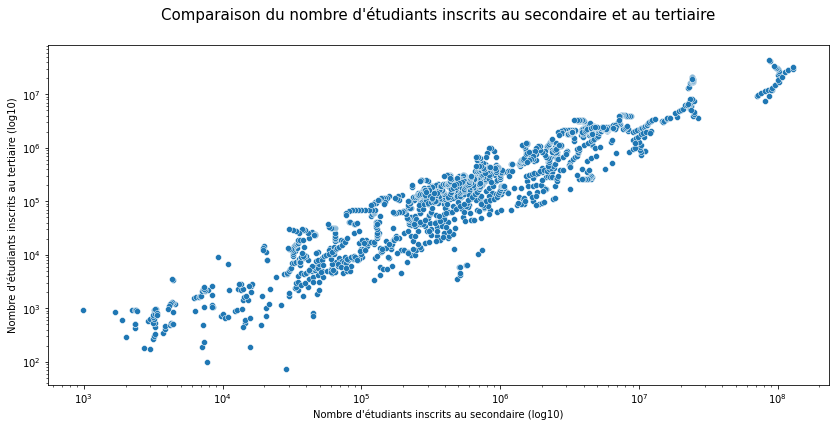

In [89]:
fig, ax = plt.subplots(figsize = (14,6.25))

sns.scatterplot(
    data = EdStatsData,
    x = indicator_secondary,
    y = indicator_tertiary
)

ax.set_xscale('log', base = 10)
ax.set_yscale('log', base = 10)

ax.set_title(
    "Comparaison du nombre d'étudiants inscrits au secondaire et au tertiaire",
    fontsize = 15,
    pad = 25
)
ax.set_xlabel(
    "Nombre d'étudiants inscrits au secondaire (log10)"
)
ax.set_ylabel(
    "Nombre d'étudiants inscrits au tertiaire (log10)"
)

plt.savefig("figures/correlation.png", format = 'png')

plt.show()

In [90]:
EdStatsData_corr = EdStatsData.dropna(axis = 0, subset = [indicator_secondary, indicator_tertiary])

In [91]:
display(Markdown(f"On peut voir que ces deux indicateurs sont largement corrélés, tant en approche Pearson que Spearman, avec:"))
display(Markdown(f"- Pearson: R = {pearsonr(EdStatsData_corr[indicator_secondary], y = EdStatsData_corr[indicator_tertiary])[0]:.2f}, pour une p-value de l'hypothèse nulle de {pearsonr(EdStatsData_corr[indicator_secondary], y = EdStatsData_corr[indicator_tertiary])[1]:.2f}"))
display(Markdown(f"- Spearman: R = {spearmanr(EdStatsData_corr[indicator_secondary], b = EdStatsData_corr[indicator_tertiary])[0]:.2f}, pour une p-value de l'hypothèse nulle de {spearmanr(EdStatsData_corr[indicator_secondary], b = EdStatsData_corr[indicator_tertiary])[1]:.2f}"))

On peut voir que ces deux indicateurs sont largement corrélés, tant en approche Pearson que Spearman, avec:

- Pearson: R = 0.88, pour une p-value de l'hypothèse nulle de 0.00

- Spearman: R = 0.93, pour une p-value de l'hypothèse nulle de 0.00

In [92]:
indicator_main = "Enrolment in secondary education, both sexes (number)"

Pour la suite de notre analyse, nous allons utiliser principalement l'indicateur parmi ces deux contenant la donnée la plus complète : le nombre d'élèves en secondaire dans chaque pays, en considérant que les pays pour lesquels cet indicateur est le plus élevé seront aussi les pays qui ont le plus d'élèves inscrits dans des parcours du tertiaire.

Bien que tous les indicateurs retenus soient complétés à au moins 50% (valeurs réelles) ou 70% (valeurs projetées), il est probable que certains pays ne soient pas aussi complets que d'autres. Afin d'utiliser une donnée aussi fiable que possible sur la durée pour notre analyse, nous allons retirer les pays pour lesquels plus d'un certain ratio des données sont manquantes, sur notre indicateur principal.

In [93]:
def country_na_remove(data, identifier, filter_indicator, na_thresh):
    
    '''
    Fonction dont le but est de renvoyer une liste de pays d'un DataFrame qui contiennent un ratio d'éléments NaN supérieur à une limite donnée.
    
    Paramètres
    ----------
    data = DataFrame sur lequel la fonction s'appliquera
    identifier = nom de colonne contenant la catégorisation souhaitée (noms de pays)
    filter_indicator = nom de colonne contenant l'indicateur sur lequel le filtre doit s'appliquer
    na_thresh = ratio maximal de NaN souhaité par pays, sur l'indicateur choisi
    
    Résultat
    --------
    List contenant les noms de pays dont le ratio de NaN est supérieur à na_thresh
    
    '''
    
    country_na = data.groupby(identifier).count().rsub(EdStatsData.groupby(identifier).size(), axis=0)
    country_size = EdStatsData.groupby(identifier).size()
    
    countries = []

    country_na = country_na.loc[:,filter_indicator]

    for country in country_na.index:
        if country_na.loc[country] > (1-na_thresh) * country_size[country]:
            countries.append(country)
    
    return countries

In [94]:
for thresh in np.arange(0.1,1.0,0.1):
    print(f"{thresh:.1f}: {len(country_na_remove(EdStatsData, 'Country Name', indicator_main, thresh))}")

0.1: 24
0.2: 33
0.3: 39
0.4: 46
0.5: 62
0.6: 71
0.7: 105
0.8: 183
0.9: 183


In [95]:
EdStatsData['Country Name'].nunique()*0.25

45.75

Nous allons fixer le ratio de données manquantes à 40%, permettant de retirer environ un quart des pays, ceux pour lesquels la donnée est la moins complète, de notre base de données.

In [96]:
countries = country_na_remove(EdStatsData, 'Country Name', indicator_main, 0.4)
countries

['American Samoa',
 'Angola',
 'Azerbaijan',
 'Bahamas, The',
 'Cambodia',
 'Channel Islands',
 'Comoros',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Curacao',
 'Equatorial Guinea',
 'Faroe Islands',
 'French Polynesia',
 'Gabon',
 'Gambia, The',
 'Greenland',
 'Guam',
 'Isle of Man',
 'Kosovo',
 'Liberia',
 'Madagascar',
 'Maldives',
 'Micronesia, Fed. Sts.',
 'Namibia',
 'New Caledonia',
 'Northern Mariana Islands',
 'Papua New Guinea',
 'Puerto Rico',
 'San Marino',
 'Saudi Arabia',
 'Sierra Leone',
 'Singapore',
 'Sint Maarten (Dutch part)',
 'Sri Lanka',
 'St. Martin (French part)',
 'Tanzania',
 'Trinidad and Tobago',
 'Turkmenistan',
 'Turks and Caicos Islands',
 'Tuvalu',
 'Uganda',
 'United Arab Emirates',
 'Vanuatu',
 'Vietnam',
 'Virgin Islands (U.S.)',
 'Zambia']

In [97]:
EdStatsData = EdStatsData.loc[~EdStatsData["Country Name"].isin(countries),:]

Certains indicateurs contiennent des valeurs en milliers, tandis que les autres contiennent des valeurs brutes. Nous allons convertir ces valeurs en milliers pour avoir la même unité.

In [98]:
EdStatsData.loc[:,forecasts_indicators] = EdStatsData.loc[:,forecasts_indicators].multiply(1000)

Ces valeurs converties, nous allons maintenant renommer les champs associés.

In [99]:
replace_list = []
for name in forecasts_indicators:
    replace_list.append([name, name.replace(r"Wittgenstein ","").replace(r"in thousands ","")])
    
EdStatsData.rename(columns = dict(replace_list), inplace = True)

In [100]:
EdStatsData.head()

,Country Name,Country Code,Region,Income Group,Languages,Year,GDP at market prices (current US$),"Population, total",GDP per capita (current US$),Internet users (per 100 people),"Enrolment in secondary education, both sexes (number)","Enrolment in tertiary education, all programmes, both sexes (number)",Projection: Population age 15-19 by highest level of educational attainment. Lower Secondary. Total,Projection: Population age 15-19 by highest level of educational attainment. Upper Secondary. Total,Projection: Population age 20-24 by highest level of educational attainment. Upper Secondary. Total,Projection: Population age 15-19 by highest level of educational attainment. Post Secondary. Total,Projection: Population age 20-24 by highest level of educational attainment. Post Secondary. Total,Projection: Population age 25-29 by highest level of educational attainment. Post Secondary. Total
0,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2000,3.632044e+09,3089027.0,1175.788981,0.114097,365664.0,40125.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2001,4.060759e+09,3060173.0,1326.970339,0.325798,377936.0,40859.0,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2002,4.435079e+09,3051010.0,1453.642777,0.390081,382205.0,42160.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2003,5.746946e+09,3039616.0,1890.681557,0.971900,396095.0,43600.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,Europe & Ce...,Upper middl...,Albanian 98...,2004,7.314865e+09,3026939.0,2416.588235,2.420388,393503.0,53014.0,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
display(Markdown(f'Notre base de données finale contient {EdStatsData.shape[0]:,.0f} lignes et {EdStatsData.shape[1]:,.0f} colonnes.'))

Notre base de données finale contient 2,877 lignes et 18 colonnes.

In [102]:
display(Markdown(f"Les lignes contiennent les informations relatives à {EdStatsData['Country Code'].nunique():,.0f} pays et {EdStatsData['Year'].nunique():,.0f} années."))

Les lignes contiennent les informations relatives à 137 pays et 21 années.

In [103]:
subset_selection = ["Country Code"] + EdStatsData.columns[6:].tolist()

Nous pouvons visualiser l'évolution du nombre de pays restant dans notre base au fil des filtres que nous avons appliqué.

In [104]:
nb_countries_add = EdStatsData.loc[:,["Country Name","Income Group"]].groupby("Income Group").nunique()
nb_countries_add.columns = ['Few missing values (Final data)']
nb_countries = nb_countries.merge(nb_countries_add, how = 'left', on = 'Income Group').reset_index()
nb_countries.head()

,Income Group,Original data,No sanctions,Few missing values (Final data)
0,High income...,31,31,31
1,High income...,44,43,22
2,Low income,34,22,14
3,Lower middl...,50,43,34
4,Upper middl...,55,44,36


In [105]:
nb_countries = nb_countries.melt(id_vars = "Income Group", var_name = 'Filter', value_name = 'Retained')
nb_countries.head()

,Income Group,Filter,Retained
0,High income...,Original data,31
1,High income...,Original data,44
2,Low income,Original data,34
3,Lower middl...,Original data,50
4,Upper middl...,Original data,55


In [106]:
income_order = EdStatsData.groupby("Income Group").mean().sort_values(by = 'GDP per capita (current US$)').index
income_order

Index(['Low income', 'Lower middle income', 'Upper middle income',
       'High income: nonOECD', 'High income: OECD'],
      dtype='object', name='Income Group')

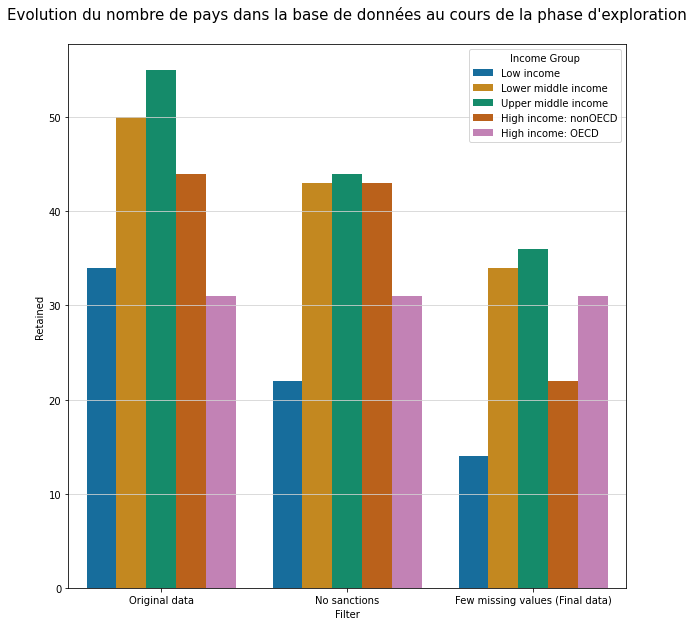

In [107]:
fig, ax = plt.subplots(figsize = (10,10))

sns.barplot(
    data = nb_countries,
    x = 'Filter',
    y = 'Retained',
    hue = 'Income Group',
    palette = 'colorblind',
    hue_order = income_order
)

ax.set_title(
    "Evolution du nombre de pays dans la base de données au cours de la phase d'exploration",
    fontsize = 15,
    pad = 25
)

ax.grid(visible = True, axis = 'y', color = 'lightgrey')

plt.savefig("figures/n_countries_evolution.png", format = "png")

plt.show()

Le premier filtre a principalement impacté les pays les plus pauvres, tandis que le second a fortement impacté les pays riches non-OECD, qui semblent manquer d'informations sur notre indicateur principal.

In [108]:
display(Markdown(f"La base contient {sum(EdStatsData.duplicated(subset = subset_selection))} lignes dupliquées, que nous définissons comme des lignes qui, pour un pays donné, contiennent des valeurs toutes identiques à une autre ligne du pays."))

La base contient 72 lignes dupliquées, que nous définissons comme des lignes qui, pour un pays donné, contiennent des valeurs toutes identiques à une autre ligne du pays.

In [109]:
print(all(EdStatsData[EdStatsData.duplicated(subset = subset_selection)].iloc[:,6:].isna()))

True


Ces lignes sont en réalité des lignes entièrement vides, donc des lignes pour lesquelles aucun indicateur n'est complété.

In [110]:
display(Markdown(f"A l'exclusion des dimensions d'identification, la base de données est complète à {EdStatsData.iloc[:,6:].count().sum() / (EdStatsData.iloc[:,6:].shape[0]*EdStatsData.shape[1]):.0%} environ, toutes années confondues. Néanmoins, nous savons qu'au moins 50% des valeurs réelles et 50% des valeurs projetées sont complètes."))

A l'exclusion des dimensions d'identification, la base de données est complète à 31% environ, toutes années confondues. Néanmoins, nous savons qu'au moins 50% des valeurs réelles et 50% des valeurs projetées sont complètes.

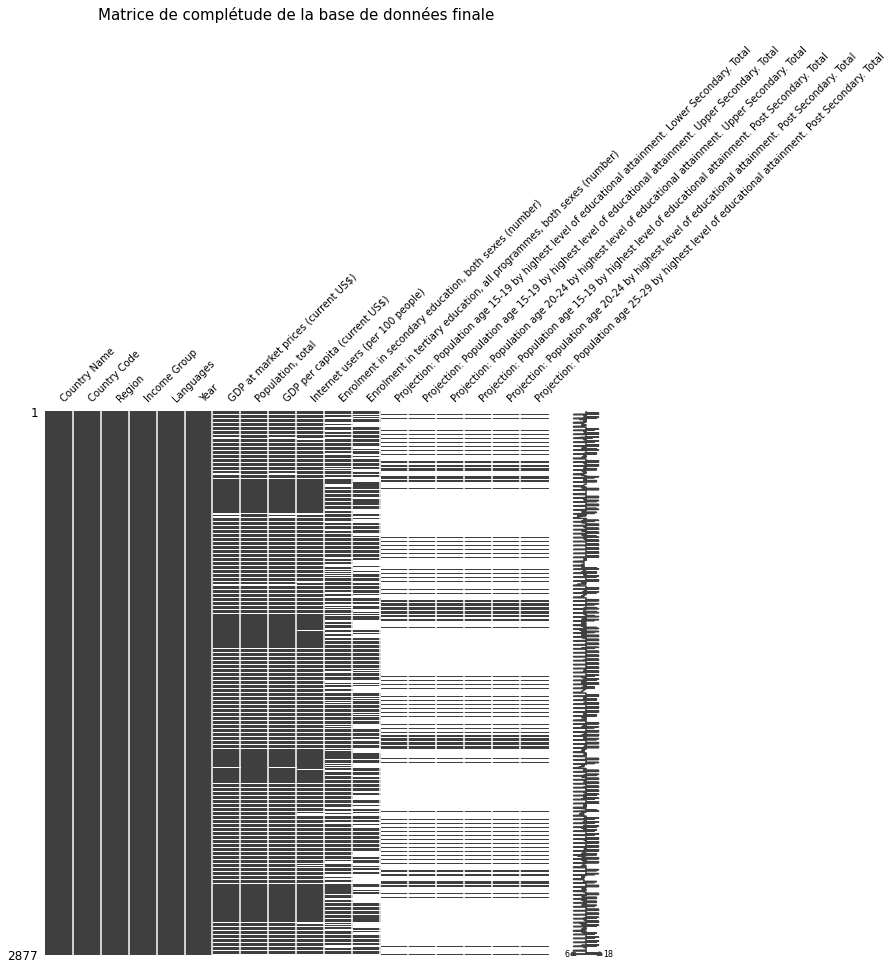

In [111]:
msno.matrix(EdStatsData, figsize = (10,10), fontsize = 10)

plt.title(
    "Matrice de complétude de la base de données finale",
    fontsize = 15,
    pad = 25
)

plt.savefig("figures/missingno.png")

plt.show()

In [112]:
EdStatsData.to_csv("wrangled_data/EdStatsData_wrangled.csv", index = False)

Nous exportons la base de données dans un fichier dédié, avant de passer à l'étape suivante.